In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')   # So we don't need to see the useless iteration output when fitting the model. 

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


In [11]:
yen_futures.shape

(1415, 10)

# Data Preparation

### Returns

<AxesSubplot:xlabel='Date'>

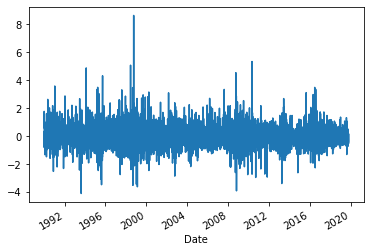

In [4]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
# YOUR CODE HERE!
settle_returns = yen_futures['Settle'].pct_change() * 100
settle_returns.dropna(inplace=True)
settle_returns.plot()

In [5]:
settle_returns.head()

Date
1990-01-03    0.584197
1990-01-04    1.756933
1990-01-05   -0.827626
1990-01-08    0.129496
1990-01-09   -0.632275
Name: Settle, dtype: float64

In [10]:
settle_returns.shape

(7514,)

### Lagged Returns 

In [6]:
# Create a lagged return using the shift function
# YOUR CODE HERE!
yen_futures['Return'] = settle_returns.copy()
yen_futures['Lagged_Return'] = settle_returns.shift()
yen_futures.dropna(inplace=True)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
2014-02-18,9831.0,9865.0,9734.0,9775.0,42.0,9775.0,203495.0,196924.0,-0.427829,0.409123
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0,-0.020460,-0.427829
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,0.020465,-0.020460
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,-0.204604,0.020465
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.020502,-0.204604


In [12]:
yen_futures.shape

(1415, 10)

### Train Test Split

In [7]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2017']
test = yen_futures['2018':]

In [8]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
# YOUR CODE HERE!
X_train = train['Lagged_Return'].to_frame()             # Lagged Return is the indepdent component. 
y_train = train['Return']                               # Return is the dependent component, it's what we're trying to predict. 
X_test = test['Lagged_Return'].to_frame() 
y_test =test['Return']

# X values are the training and y values are the testing 

In [9]:
X_train

,Lagged_Return
Date,
2014-02-18,0.409123
2014-02-19,-0.427829
2014-02-20,-0.020460
2014-02-21,0.020465
2014-02-24,-0.204604
...,...
2017-12-22,0.084621
2017-12-26,0.118370
2017-12-27,0.118230


# Linear Regression Model

In [13]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
# YOUR CODE HERE!
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [14]:
# Make a prediction of "y" values using just the test dataset
# YOUR CODE HERE!
predictions = model.predict(X_test)

In [15]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
# YOUR CODE HERE!
out_of_sample_results = y_test.to_frame()
out_of_sample_results['Predicted Return'] = predictions

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

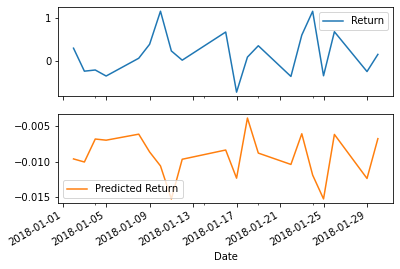

In [16]:
# Plot the first 20 predictions vs the true values
# YOUR CODE HERE!
out_of_sample_results[:20].plot(subplots=True)

# Based on the holdout data. The actual returns versus the predicted returns are inversely correlated. It seems our model does a bad job predicting returns. 

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [17]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# YOUR CODE HERE!
mse = mean_squared_error(
    out_of_sample_results['Return'],                    # actual returns
    out_of_sample_results['Predicted Return']           # predicted returns
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
# YOUR CODE HERE!
out_of_sample_rmse = np.sqrt(mse)
print(f'Out-of-Sample Root Mean Squared Error (RMSE): {out_of_sample_rmse}')

# Not a good RMSE. The RMSE is 0.4154. The closer it is to 1, the more predicted data points are on the slope of the prediction line. This score based on the holdout data is closer to zero.

Out-of-Sample Root Mean Squared Error (RMSE): 0.41545437184712763


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [22]:
# Construct a dataframe using just the "y" training data:
# YOUR CODE HERE!
in_sample_predictions = model.predict(X_train)     # run the predict on the data model is exposed to. 
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
# YOUR CODE HERE!
in_sample_results['In-Sample Predicted Return'] = in_sample_predictions

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
# YOUR CODE HERE!
in_sample_mse = mean_squared_error(
    in_sample_results['Return'],                               # actual returns
    in_sample_results['In-Sample Predicted Return']            # preducted returns
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
# YOUR CODE HERE!
in_sample_rmse = np.sqrt(in_sample_mse)
print(f'In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}')

# Higher RMSE of 0.5962. We want the score to be closer to 1. Unlike our holdout data that wasn't exposed to the model to make preictions, this data that the model knows performed better at making accurate predictions. 

In-sample Root Mean Squared Error (RMSE): 0.5962037920929946


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

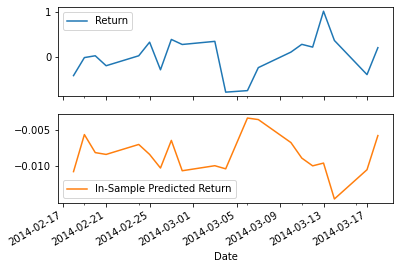

In [23]:
in_sample_results[:20].plot(subplots=True)

# Conclusions

YOUR CONCLUSIONS HERE!

We are tasked with making a decision whether to buy Japanese Yen (JPY) today based on the next predictions of the returns.  

This model does perform well predicting returns on Yen futures. My decision would be not to buy any Yen if we looked at the predicted data.  

* The RMSE score on the holdout testing data was **0.4154** which is closer to zero. A good RMSE on the holdout data to predict accurate returns is closer to 1, which would indicate our predicted data points are on the predicted slope line.
* When we graphed the actual vs predicted Yen value returns based on the *holdout* data, the predicted returns were inverse to the actual.
* I have no confidence in the accuracy of the model. I would not buy the Yen today.  
* The RMSE score on the exposed data was **0.596** which is higher than the score of the holdout data. So the model can more accurately predict on the exposed data. 